In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read in mCT data

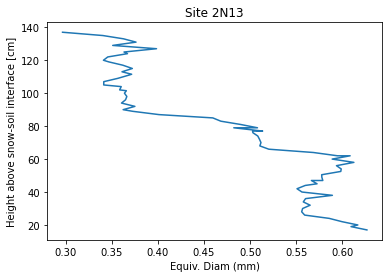

,height (cm),SSA (m2/kg),Equiv. Diam (mm)
0,17.0,10.439117,0.626784
1,19.0,10.734602,0.609531
2,20.0,10.605736,0.616937
3,22.0,10.908942,0.599790
4,24.0,11.167612,0.585897
...,...,...,...
66,129.0,18.648615,0.350861
67,131.0,17.393446,0.376181
68,133.0,18.042126,0.362655
69,135.0,19.234373,0.340176


In [2]:
frames = pickle.load(open('../data/microCT/processed_mCT.p', 'rb'))

site = '2N13'

# extract dataframe from dict

mct_df = frames[site]

# plot

fig,ax = plt.subplots()
ax.plot(mct_df['Equiv. Diam (mm)'],
         mct_df['height (cm)'])

ax.set_xlabel('Equiv. Diam (mm)')
ax.set_ylabel('Height above snow-soil interface [cm]')

ax.set_title(f'Site {site.upper()}')

plt.show()

# return df to get a look at it

mct_df

# Read SMP data

In [3]:
from snowmicropyn import Profile, density_ssa

window_size = 4

p = Profile.load(f'../data/SMP/SNEX20_SMP_S19M1172_2N13_20200206.PNT')

p.detect_ground()
# p.detect_surface()

df_C2020 = density_ssa.calc(p.samples,coeff_model='C2020',window=window_size)
df_C2020.columns = ['distance', 'Cdensity', 'Cssa']

df_P2015 = density_ssa.calc(p.samples,coeff_model='P2015',window=window_size)
df_P2015.columns = ['distance', 'Pdensity', 'Pssa']

df_combined = pd.merge(left=df_P2015, right=df_C2020)

df_combined = df_combined[(df_combined['distance'] < p.ground)]

df_combined['distance_up'] = (p.ground - df_combined['distance'])/10

df_combined

Latitude value -99999.0 invalid, replacing by None
Longitude value -99999.0 invalid, replacing by None
/Users/mtd/opt/anaconda3/envs/snowex-microstructure/lib/python3.8/site-packages/snowmicropyn-1.0.1-py3.8.egg/snowmicropyn/loewe2012.py:58: RuntimeWarning: invalid value encountered in double_scalars
  delta = -(3. / 2) * c_f[n - 1] / (c_f[n] - c_f[n - 1]) * spatial_res


ZeroDivisionError: float division by zero

NameError: name 'df_combined' is not defined

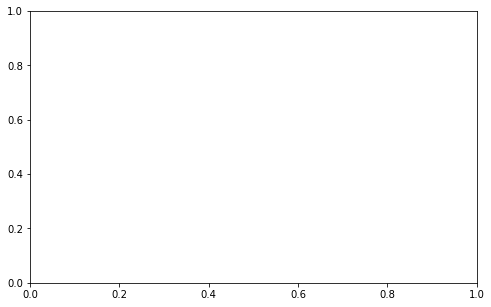

In [4]:
fig,ax = plt.subplots(figsize=(8,5))


ax.plot(df_combined['Cssa'],
        df_combined['distance_up'],
        color='r',label='C2020')

ax.plot(df_combined['Pssa'],
        df_combined['distance_up'],
        color='g',label='P2015')

ax.plot(mct_df['SSA (m2/kg)'],
         mct_df['height (cm)'],
       label='mCT',
        color='k',
       zorder=5)

ax.set_xlabel('SSA (m2/kg)', fontsize='x-large')
ax.set_ylabel('Height above snow-soil interface [cm]', fontsize='x-large')

ax.set_title(f'Site {site.upper()}', fontsize='x-large')

ax.legend(loc='lower right', fontsize='x-large')

plt.show()